In [39]:
# Optional: install packages and check environment
!pip install -q opencv-python-headless

import os, sys, random
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.optimizers import Adam

In [40]:
# Config
BASE_PATH = "/kaggle/input/didadataset"
dataset_path = os.path.join(BASE_PATH, "DIDA_12000_String_Digit_Images")
IMAGE_EXTENSIONS = ["jpg","jpeg","png"]

IMG_SIZE = 256
CHANNELS = 1
SEED = 42
BATCH_SIZE = 16
EPOCHS = 50
LR = 0.001

random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [41]:
# Get all images
all_images = []
for ext in IMAGE_EXTENSIONS:
    all_images.extend(glob.glob(os.path.join(dataset_path, "**/*."+ext), recursive=True))
all_images = all_images[:1000]  # limit for speed
print("Total images:", len(all_images))
print("Example:", all_images[0])

Total images: 1000
Example: /kaggle/input/didadataset/DIDA_12000_String_Digit_Images/DIDA_1/7981.jpg


In [42]:
# Preprocessing
def preprocess_image(path):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img = img / 255.0
    return np.expand_dims(img, axis=-1)  # shape (H,W,1)

# Build X, Y
X, Y = [], []
for path in all_images:
    clean = preprocess_image(path)
    noisy = clean + 0.4 * np.random.normal(loc=0.0, scale=1.0, size=clean.shape)
    noisy = np.clip(noisy, 0.0, 1.0)
    X.append(noisy)
    Y.append(clean)

X = np.array(X, dtype=np.float32)
Y = np.array(Y, dtype=np.float32)
print("X shape:", X.shape, "Y shape:", Y.shape)

# Split
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=SEED)

X shape: (1000, 256, 256, 1) Y shape: (1000, 256, 256, 1)


In [43]:
# Build U-Net
def build_unet(img_size=IMG_SIZE):
    inputs = layers.Input((img_size, img_size, 1))

    # Encoder
    c1 = layers.Conv2D(32, 3, activation="relu", padding="same")(inputs)
    p1 = layers.MaxPooling2D((2,2))(c1)
    
    c2 = layers.Conv2D(64, 3, activation="relu", padding="same")(p1)
    p2 = layers.MaxPooling2D((2,2))(c2)
    
    c3 = layers.Conv2D(128, 3, activation="relu", padding="same")(p2)
    
    # Decoder
    u1 = layers.UpSampling2D((2,2))(c3)
    m1 = layers.Concatenate()([u1, c2])
    c4 = layers.Conv2D(64, 3, activation="relu", padding="same")(m1)
    
    u2 = layers.UpSampling2D((2,2))(c4)
    m2 = layers.Concatenate()([u2, c1])
    c5 = layers.Conv2D(32, 3, activation="relu", padding="same")(m2)
    
    outputs = layers.Conv2D(1, 1, activation="sigmoid")(c5)
    return models.Model(inputs, outputs)

model = build_unet()
optimizer = Adam(learning_rate=LR)
model.compile(optimizer=optimizer, loss="mae", metrics=["accuracy"])
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_18 (Conv2D)  │ (None, 256, 256,  │        320 │ input_layer_3[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_6     │ (None, 128, 128,  │          0 │ conv2d_18[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_19 (Conv2D)  │ (None, 128, 128,  │     18,496 │ max_pooling2d_6[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_7     │ (None, 64, 64,    │          0 │ conv2d_19[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_20 (Conv2D)  │ (None, 64, 64,    │     73,856 │ max_pooling2d_7[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_6     │ (None, 128, 128,  │          0 │ conv2d_20[0][0]   │
│ (UpSampling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_6       │ (None, 128, 128,  │          0 │ up_sampling2d_6[… │
│ (Concatenate)       │ 192)              │            │ conv2d_19[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_21 (Conv2D)  │ (None, 128, 128,  │    110,656 │ concatenate_6[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_7     │ (None, 256, 256,  │          0 │ conv2d_21[0][0]   │
│ (UpSampling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_7       │ (None, 256, 256,  │          0 │ up_sampling2d_7[… │
│ (Concatenate)       │ 96)               │            │ conv2d_18[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_22 (Conv2D)  │ (None, 256, 256,  │     27,680 │ concatenate_7[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_23 (Conv2D)  │ (None, 256, 256,  │         33 │ conv2d_22[0][0]   │
│                     │ 1)                │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 231,041 (902.50 KB)

 Trainable params: 231,041 (902.50 KB)

 Non-trainable params: 0 (0.00 B)

In [44]:
# Batch progress callback
class BatchProgress(callbacks.Callback):
    def __init__(self, every_n_batches=10):
        super().__init__()
        self.every_n_batches = every_n_batches

    def on_train_batch_end(self, batch, logs=None):
        if (batch + 1) % self.every_n_batches == 0:
            print(f"Processed {batch+1} batches. Loss: {logs['loss']:.4f}")

progress_callback = BatchProgress(every_n_batches=15)

In [45]:
# Train
history = model.fit(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[progress_callback]
)

Epoch 1/50
14/50 ━━━━━━━━━━━━━━━━━━━━ 4s 120ms/step - accuracy: 0.0000e+00 - loss: 0.0982Processed 15 batches. Loss: 0.0912
29/50 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - accuracy: 3.5319e-08 - loss: 0.0913Processed 30 batches. Loss: 0.0779
44/50 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 5.8917e-08 - loss: 0.0851Processed 45 batches. Loss: 0.0684
50/50 ━━━━━━━━━━━━━━━━━━━━ 12s 151ms/step - accuracy: 6.1787e-08 - loss: 0.0826 - val_accuracy: 2.2888e-07 - val_loss: 0.0482
Epoch 2/50
14/50 ━━━━━━━━━━━━━━━━━━━━ 4s 121ms/step - accuracy: 0.0000e+00 - loss: 0.0449Processed 15 batches. Loss: 0.0446
29/50 ━━━━━━━━━━━━━━━━━━━━ 2s 121ms/step - accuracy: 3.5319e-08 - loss: 0.0445Processed 30 batches. Loss: 0.0436
44/50 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 5.8917e-08 - loss: 0.0440Processed 45 batches. Loss: 0.0421
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 131ms/step - accuracy: 6.1787e-08 - loss: 0.0437 - val_accuracy: 2.2888e-07 - val_loss: 0.0391
Epoch 3/50
14/50 ━━━━━━━━━━━━━━━━━━━━ 4s 122ms/st

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


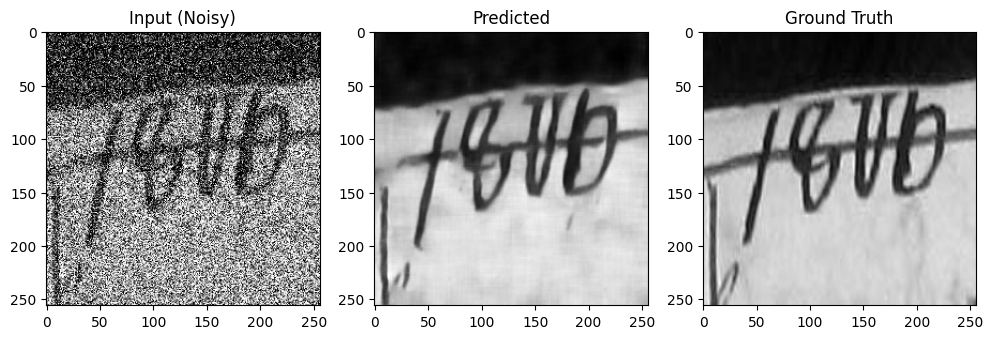

In [54]:
# Visualize prediction
idx = np.random.randint(0, len(X_val))
noisy_img = X_val[idx]
clean_img = Y_val[idx]
pred_img = model.predict(np.expand_dims(noisy_img, axis=0))[0]

plt.figure(figsize=(12,4))
plt.subplot(1,3,1); plt.imshow(noisy_img.squeeze(), cmap="gray"); plt.title("Input (Noisy)")
plt.subplot(1,3,2); plt.imshow(pred_img.squeeze(), cmap="gray"); plt.title("Predicted")
plt.subplot(1,3,3); plt.imshow(clean_img.squeeze(), cmap="gray"); plt.title("Ground Truth")
plt.show()

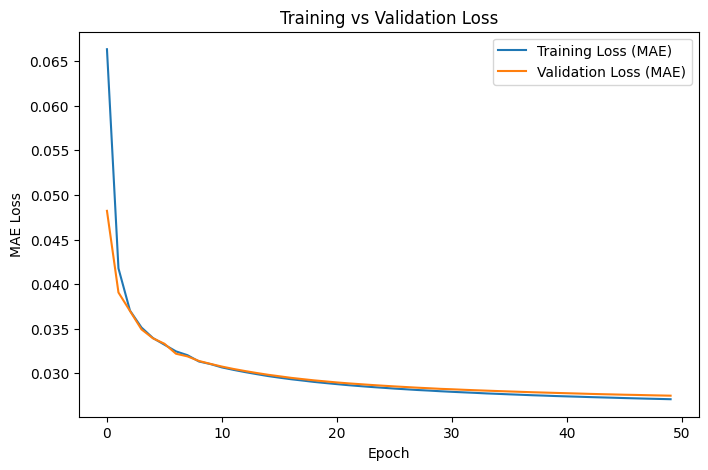

In [49]:
import matplotlib.pyplot as plt

# Get loss values from history
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot
plt.figure(figsize=(8,5))
plt.plot(train_loss, label='Training Loss (MAE)')
plt.plot(val_loss, label='Validation Loss (MAE)')
plt.xlabel('Epoch')
plt.ylabel('MAE Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.show()



In [50]:
print("Final Training MAE:", train_loss[-1])
print("Final Validation MAE:", val_loss[-1])


Final Training MAE: 0.02709767408668995
Final Validation MAE: 0.027494899928569794


In [55]:
# Print numerical loss values for each epoch
for i, (t, v) in enumerate(zip(history.history['loss'], history.history['val_loss']), 1):
    print(f"Epoch {i:2d}: Train MAE = {t:.4f}, Val MAE = {v:.4f}")


Epoch  1: Train MAE = 0.0663, Val MAE = 0.0482
Epoch  2: Train MAE = 0.0418, Val MAE = 0.0391
Epoch  3: Train MAE = 0.0370, Val MAE = 0.0370
Epoch  4: Train MAE = 0.0351, Val MAE = 0.0349
Epoch  5: Train MAE = 0.0340, Val MAE = 0.0339
Epoch  6: Train MAE = 0.0332, Val MAE = 0.0333
Epoch  7: Train MAE = 0.0325, Val MAE = 0.0322
Epoch  8: Train MAE = 0.0320, Val MAE = 0.0319
Epoch  9: Train MAE = 0.0313, Val MAE = 0.0314
Epoch 10: Train MAE = 0.0310, Val MAE = 0.0311
Epoch 11: Train MAE = 0.0307, Val MAE = 0.0308
Epoch 12: Train MAE = 0.0304, Val MAE = 0.0305
Epoch 13: Train MAE = 0.0301, Val MAE = 0.0303
Epoch 14: Train MAE = 0.0299, Val MAE = 0.0300
Epoch 15: Train MAE = 0.0297, Val MAE = 0.0298
Epoch 16: Train MAE = 0.0295, Val MAE = 0.0297
Epoch 17: Train MAE = 0.0293, Val MAE = 0.0295
Epoch 18: Train MAE = 0.0292, Val MAE = 0.0294
Epoch 19: Train MAE = 0.0290, Val MAE = 0.0292
Epoch 20: Train MAE = 0.0289, Val MAE = 0.0291
Epoch 21: Train MAE = 0.0288, Val MAE = 0.0290
Epoch 22: Tra

In [57]:
MODEL_FILE = "/kaggle/working/ai_model1.h5"
model.save(MODEL_FILE)
print(f"Model saved as HDF5: {MODEL_FILE}")


Model saved as HDF5: /kaggle/working/ai_model1.h5
